In [1]:
import json
import pandas as pd
import joblib
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
from config import config, feature_mapper

/Users/warisaraporn.l/Documents/thai-talent-wow/talentwow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name '__file__' is not defined

In [2]:
json_result = {}

In [3]:
# model results
model_config = json.load(open(f'../{config.MODEL_CONFIG_PATH}', 'r'))
model_interpretation = joblib.load(f'../{config.MODEL_INTERPRETATION_PATH}')
model_result = pd.read_parquet(f'../{config.MODEL_RESULTS_PATH}')

employee_metadata = pd.read_csv(f'../{config.FEATURE_ENGINEERED_PATH}')
employee_metadata['execution_date'] = pd.to_datetime(employee_metadata['execution_date'])
employee_metadata = employee_metadata.sort_values(['emp_id', 'execution_date']).drop_duplicates('emp_id', keep='last') # ใช้ข้อมูลล่าสุดของพนักงานแต่ละคน
employee_metadata['model_predicted_termination'] = employee_metadata['emp_id'].map(
    model_result.set_index('emp_id')['predicted_termination']
)
employee_metadata['model_predicted_termination_probability'] = employee_metadata['emp_id'].map(
    model_result.set_index('emp_id')['termination_probability']
)
# get job level and position information
_employee_position_df = pd.read_csv(f'../{config.EMPLOYEE_POSITION_DATA}')
_employee_position_df = _employee_position_df.sort_values(by=['employee_id', 'created_at'], ascending=[True, False]).drop_duplicates(subset=['employee_id'], keep='first')
_position_df = pd.read_csv(f'../{config.POSITION_DATA}')
employee_metadata['job_level_name'] = employee_metadata['job_level'].map(config.JOB_LEVEL_MAPPER)
employee_metadata['position_id'] = employee_metadata['emp_id'].map(_employee_position_df.set_index('employee_id')['position_id'])
employee_metadata['job_title'] = employee_metadata['position_id'].map(_position_df.set_index('id')['name'])

# terminatio emp
termination_emp = employee_metadata[(employee_metadata['model_predicted_termination'] == True) | (employee_metadata['termination_value'] > 0)]

# shap
features = model_config['features']
metadata_columns = ['emp_id', 'job_title', 'job_level_name', 'department_name']

shap_df_list = []
for emp_id, shap_explanation in model_interpretation.items():
    shap_values = shap_explanation.values
    _temp_df = pd.DataFrame([shap_values], columns=features)
    _temp_df['emp_id'] = emp_id
    shap_df_list.append(_temp_df)

all_shap_df = pd.concat(shap_df_list, ignore_index=True)
shap_with_metadata = pd.merge(all_shap_df, employee_metadata[metadata_columns], on='emp_id', how='left')

#### overall summary

In [4]:
print('Overall Summary')

predicted_execution_date = employee_metadata['execution_date'].max() + relativedelta(months=1)
predicted_end_date = predicted_execution_date + relativedelta(months=3) - relativedelta(days=1)
print(f"Prediction As of {predicted_execution_date.strftime('%Y-%m-%d')} to {predicted_end_date.strftime('%Y-%m-%d')}")
print(f"Total Employees: {len(model_result)}")
print(f"Total Employees Left: {employee_metadata[employee_metadata['termination_value'] > 0].drop_duplicates('emp_id').shape[0]}")
print(f"Employees Predicted to Leave: {employee_metadata[employee_metadata['model_predicted_termination'] == True].shape[0]}")
print(f"Average Retention Probability: {employee_metadata['model_predicted_termination_probability'].mean():.2f}")

# write json result
json_result['overall_summary'] = {
    'prediction_start_date': predicted_execution_date.strftime('%Y-%m-%d'),
    'prediction_end_date': predicted_end_date.strftime('%Y-%m-%d'),
    'total_employees': len(model_result),
    'total_employees_left': employee_metadata[employee_metadata['termination_value'] > 0].drop_duplicates('emp_id').shape[0],
    'employees_predicted_to_leave': employee_metadata[employee_metadata['model_predicted_termination'] == True].shape[0],
    'average_retention_probability': employee_metadata['model_predicted_termination_probability'].mean()
}

Overall Summary
Prediction As of 2025-08-31 to 2025-11-29
Total Employees: 18
Total Employees Left: 10
Employees Predicted to Leave: 7
Average Retention Probability: 0.07


Employee Termination Proportion by Department


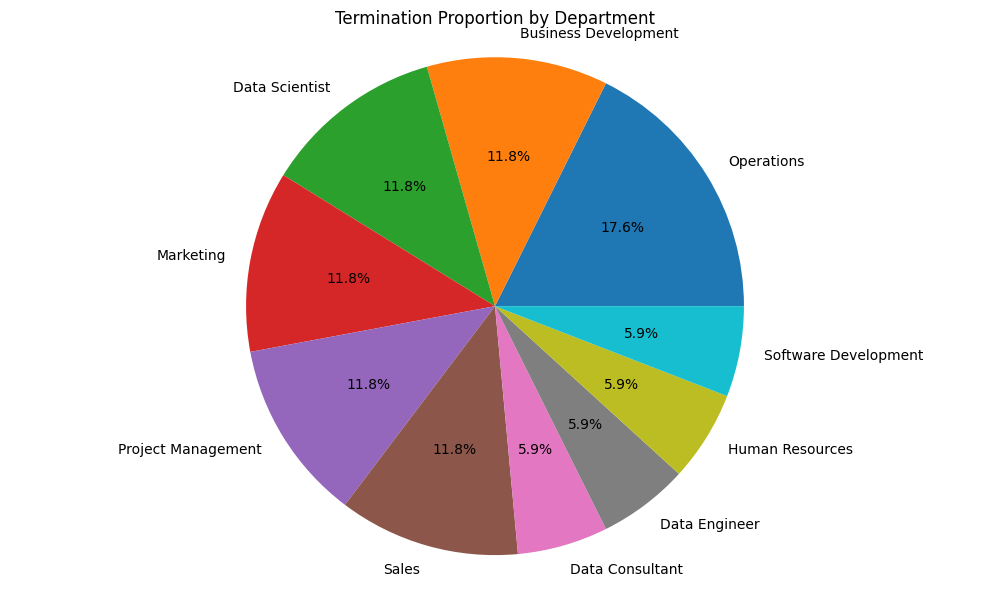

In [5]:
print("Employee Termination Proportion by Department")
# จำนวนคนออกตาม department (รวมทั้งคนที่ออกไปแล้วแลพ predicted ว่าจะออก) == ดูอดีต (และกึ่งอนาคต)

department_count = termination_emp.groupby('department_name')['termination_value'].count().to_frame('termination_count').reset_index()
department_count = department_count.sort_values('termination_count', ascending=False)

# write json result
json_result['termination_proportion_by_department'] = department_count.to_dict(orient='records')

# plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(department_count['termination_count'], labels=department_count['department_name'], autopct='%1.1f%%')
plt.title('Termination Proportion by Department')
plt.axis('equal')
plt.tight_layout()

Employee Termination Proportion by Job Level


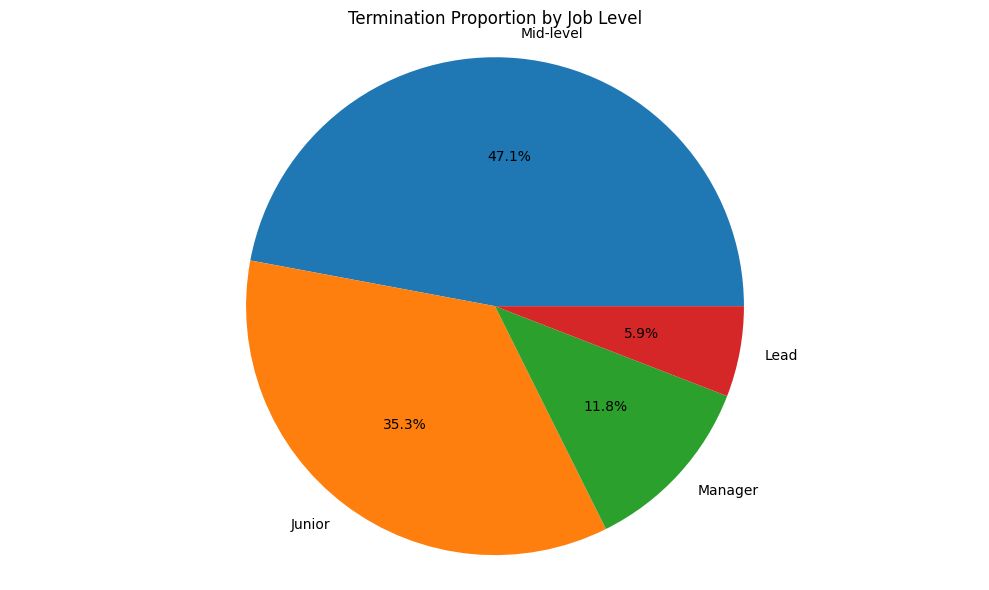

In [6]:
print("Employee Termination Proportion by Job Level")
# จำนวนคนออกตาม job level (รวมทั้งคนที่ออกไปแล้วแลพ predicted ว่าจะออก) == ดูอดีต (และกึ่งอนาคต)


level_count = termination_emp.groupby('job_level')['termination_value'].count().to_frame('termination_count').reset_index()
level_count = level_count.sort_values('termination_count', ascending=False)
level_count['level_name'] = level_count['job_level'].map(config.JOB_LEVEL_MAPPER)

# write json result
json_result['termination_proportion_by_job_level'] = level_count[['level_name', 'termination_count']].to_dict(orient='records')

# plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(level_count['termination_count'], labels=level_count['level_name'], autopct='%1.1f%%')
plt.title('Termination Proportion by Job Level')
plt.axis('equal')
plt.tight_layout()

Average Termination Probability by Department


<Axes: xlabel='department_name', ylabel='model_predicted_termination_probability'>

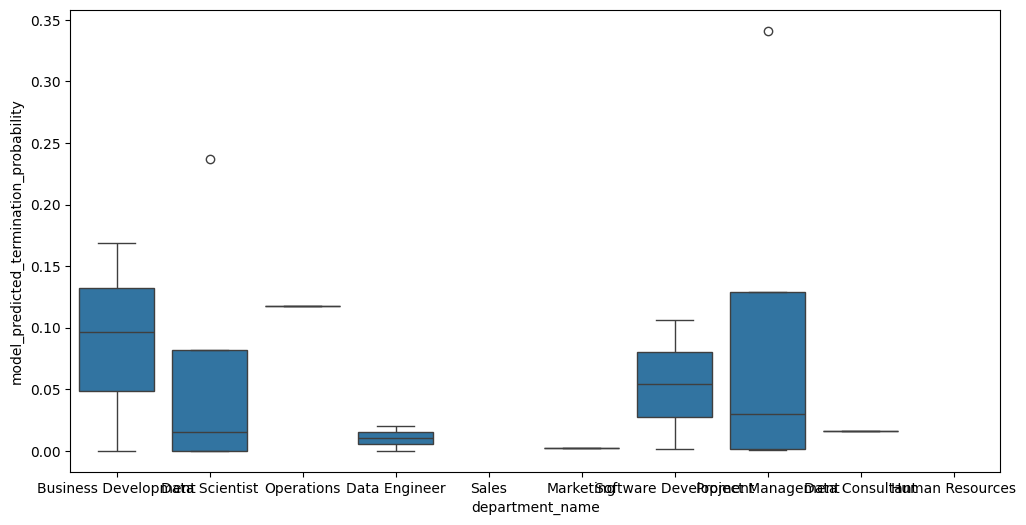

In [7]:
print("Average Termination Probability by Department")
# ค่าเฉลี่ยของ termination probability ตาม department (คาดการณ์อนาคต)
##### จริงๆอยากได้เป็น beeswarm  แต่เหมือน e-chart จะทำไม่ได้

department_prob = employee_metadata.groupby('department_name')['model_predicted_termination_probability'].mean().reset_index()
department_prob.columns = ['department_name', 'average_termination_probability']

# write json result
# json_result['average_termination_probability_by_department'] = department_prob.to_dict(orient='records')

# plot beeswarm plot by department
plt.figure(figsize=(12, 6))
sns.boxplot(data=employee_metadata, x='department_name', y='model_predicted_termination_probability')

Average Termination Probability by Job Level


<Axes: xlabel='job_level_name', ylabel='model_predicted_termination_probability'>

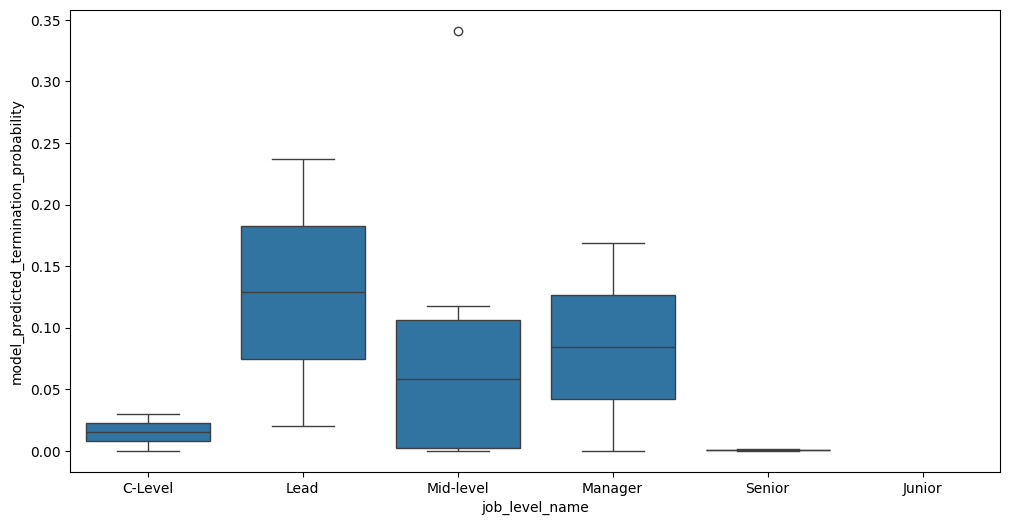

In [8]:
print("Average Termination Probability by Job Level")
# ค่าเฉลี่ยของ termination probability ตาม job level (คาดการณ์อนาคต)
##### จริงๆอยากได้เป็น beeswarm  แต่เหมือน e-chart จะทำไม่ได้

job_level_prob = employee_metadata.groupby('job_level_name')['model_predicted_termination_probability'].mean().reset_index()
job_level_prob.columns = ['job_level', 'average_termination_probability']

# write json result
# json_result['average_termination_probability_by_job_level'] = job_level_prob.to_dict(orient='records')

# plot beeswarm plot by department
plt.figure(figsize=(12, 6))
sns.boxplot(data=employee_metadata, x='job_level_name', y='model_predicted_termination_probability')

Top 5 Reasons Why Empoyees Quit


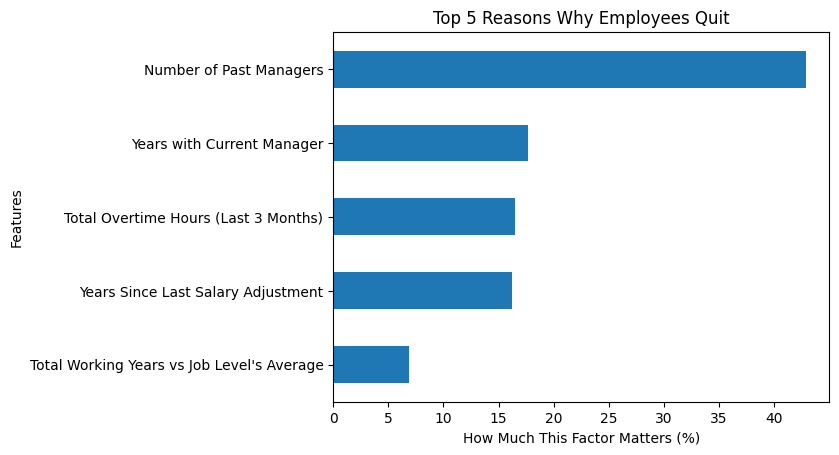

In [11]:
print("Top 5 Reasons Why Empoyees Quit")
# 5 สาเหตุที่พนักงานลาออกมากที่สุด

num_features = 5
mean_importance = (all_shap_df.mean(axis=0, skipna=True).sort_values(ascending=False)).to_frame('impact_value')
mean_importance = mean_importance.drop('emp_id', errors='ignore')
mean_importance = mean_importance.reset_index().rename(columns={'index': 'feature'})
mean_importance = mean_importance.head(num_features)

# Convert to percentage of total
total_impact = mean_importance['impact_value'].sum()
mean_importance['impact_percentage'] = (mean_importance['impact_value'] / total_impact) * 100

mean_importance['feature_name'] = mean_importance['feature'].map(feature_mapper.FEARURES_MEANING_MAPPER)

# recommendation action
mean_importance['recommendation_action'] = mean_importance['feature'].map(feature_mapper.FEATURES_ACTION_MAPPER)

# write json result
json_result['top_reasons_for_quitting'] = mean_importance[['feature_name', 'impact_percentage', 'recommendation_action']].to_dict(orient='records')

# plot barh
mean_importance.sort_values(by='impact_percentage', ascending=True).plot(
    kind='barh', y='impact_percentage', x='feature_name', legend=False
)
plt.title('Top 5 Reasons Why Employees Quit')
plt.xlabel('How Much This Factor Matters (%)')
plt.ylabel('Features')
plt.show()

In [12]:
json_result

{'overall_summary': {'prediction_start_date': '2025-08-31',
  'prediction_end_date': '2025-11-29',
  'total_employees': 18,
  'total_employees_left': 10,
  'employees_predicted_to_leave': 7,
  'average_retention_probability': 0.06642316541518099},
 'termination_proportion_by_department': [{'department_name': 'Operations',
   'termination_count': 3},
  {'department_name': 'Business Development', 'termination_count': 2},
  {'department_name': 'Data Scientist', 'termination_count': 2},
  {'department_name': 'Marketing', 'termination_count': 2},
  {'department_name': 'Project Management', 'termination_count': 2},
  {'department_name': 'Sales', 'termination_count': 2},
  {'department_name': 'Data Consultant', 'termination_count': 1},
  {'department_name': 'Data Engineer', 'termination_count': 1},
  {'department_name': 'Human Resources', 'termination_count': 1},
  {'department_name': 'Software Development', 'termination_count': 1}],
 'termination_proportion_by_job_level': [{'level_name': 'Mi

#### evaluation by employee

In [14]:
termination_shap_emp = employee_metadata[employee_metadata['model_predicted_termination'] == True].drop_duplicates('emp_id')[['emp_id']]
termination_shap_emp = shap_with_metadata[shap_with_metadata['emp_id'].isin(termination_shap_emp['emp_id'])]
termination_shap_emp['predicted_temination_probability'] = termination_shap_emp['emp_id'].map(model_result.set_index('emp_id')['termination_probability'])
termination_shap_emp

/var/folders/x_/4p1v5h053s7_q_45w6c5prs00000gr/T/ipykernel_90846/3540217691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  termination_shap_emp['predicted_temination_probability'] = termination_shap_emp['emp_id'].map(model_result.set_index('emp_id')['termination_probability'])


,total_working_year_z_job_level,total_working_year_z_manager,avg_performance_score,performance_score_z_department,performance_score_z_job_level,year_since_last_salary_adjustment,avg_time_to_promotion,year_with_current_manager,total_ot_hours_3_months,num_past_manager,age,performance_score_z_manager,time_since_last_promotion,total_working_year,num_skills,emp_id,job_title,job_level_name,department_name,predicted_temination_probability
2,0.009259,0.009184,-0.054552,-0.002154,0.013527,0.043964,0.008912,0.062595,0.125665,-0.005138,-0.002679,0.007022,0.009298,0.020260,-0.020335,990003,Lead Data Scientist,Lead,Data Scientist,0.237148
7,0.006288,-0.012749,-0.003214,-0.001437,0.001283,-0.000768,-0.000370,0.020303,-0.009469,0.075062,0.000381,0.011548,0.001505,0.001346,0.004373,990013,Mid Software Developer,Mid-level,Software Development,0.106403
8,0.005790,-0.003475,0.014536,-0.000808,0.010294,0.049595,-0.000699,0.052411,-0.008081,-0.001569,0.000717,0.001895,0.001086,0.012970,0.021668,990014,Business Development Manager,Manager,Business Development,0.168652
11,0.001115,-0.015982,0.002502,-0.001044,0.000965,-0.000922,0.002296,0.019206,-0.003243,0.073400,0.000141,0.005746,-0.003959,0.004634,-0.001034,990019,Mid Business Development,Mid-level,Business Development,0.096140
12,0.000958,-0.013434,0.002587,0.007825,-0.010388,-0.000985,-0.000291,-0.019410,0.015409,0.054659,0.000163,0.004067,0.001028,0.001596,0.002263,990020,Mid Project Management,Mid-level,Project Management,0.058369
13,0.020424,-0.034474,0.026408,-0.004479,-0.011966,-0.003472,0.002474,-0.010048,0.122818,-0.009641,-0.005359,-0.005286,0.006451,-0.004337,0.015668,990021,Mid Operations,Mid-level,Operations,0.117502
14,0.002618,0.110081,-0.002591,-0.003631,0.008300,0.004127,0.002296,0.018839,-0.003612,0.176538,0.000101,0.019139,-0.003959,-0.001296,0.002106,990022,Mid Project Management,Mid-level,Project Management,0.341377


In [28]:
# write result to JSON
json_topic = "termination_reason_by_employee"
termination_reason_by_employee = {}

for emp_id in termination_shap_emp['emp_id'].unique():
    predicted_termination_probability = termination_shap_emp[termination_shap_emp['emp_id'] == emp_id]['predicted_temination_probability'].values[0]

    # Get SHAP values for this employee
    _emp_shap_t = termination_shap_emp[termination_shap_emp['emp_id'] == emp_id][features]
    _emp_shap_t = _emp_shap_t.T.reset_index()
    _emp_shap_t.columns = ['feature', 'impact_value']

    # Calculate absolute mean threshold and Keep only values above threshold
    abs_mean_shap_value = _emp_shap_t['impact_value'].abs().mean()
    _emp_shap_t = _emp_shap_t[_emp_shap_t['impact_value'].abs() > abs_mean_shap_value]

    # Convert to percentage of total absolute impact
    total_abs_impact = _emp_shap_t['impact_value'].abs().sum()
    _emp_shap_t['impact_percentage'] = (_emp_shap_t['impact_value'].abs() / total_abs_impact) * 100

    # Map readable names
    _emp_shap_t['feature_name'] = _emp_shap_t['feature'].map(feature_mapper.FEARURES_MEANING_MAPPER)
    _emp_shap_t['recommendation_action'] = _emp_shap_t['feature'].map(feature_mapper.FEATURES_ACTION_MAPPER)

    # Sort
    _emp_shap_t.sort_values(by='impact_percentage', ascending=False, inplace=True)

    # write to JSON
    termination_reason_by_employee[str(emp_id)] = {
        'predicted_termination_probability': predicted_termination_probability,
        'impact_factors': _emp_shap_t[['feature_name', 'impact_percentage', 'recommendation_action']].to_dict(orient='records')
    }

json_result[json_topic] = termination_reason_by_employee

[990003 990013 990014 990019 990020 990021 990022]


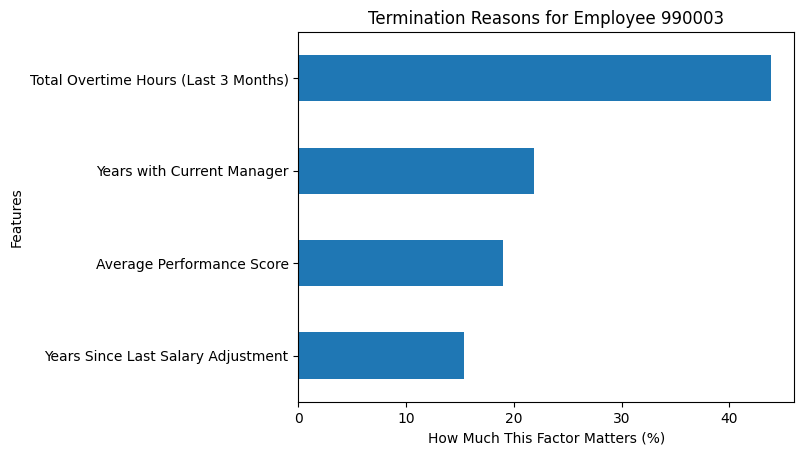

In [29]:
# try sampel plot
print(termination_shap_emp['emp_id'].unique())
sample_emp_id = 990003

# plot barh for sample employee
_temp = termination_reason_by_employee[str(sample_emp_id)]['impact_factors'] 
_temp_df = pd.DataFrame(_temp)
_temp_df.sort_values(by='impact_percentage', ascending=True).plot(
    kind='barh', y='impact_percentage', x='feature_name', legend=False
)
plt.title(f'Termination Reasons for Employee {sample_emp_id}')
plt.xlabel('How Much This Factor Matters (%)')
plt.ylabel('Features')
plt.show()

In [30]:
json_result

{'overall_summary': {'prediction_start_date': '2025-08-31',
  'prediction_end_date': '2025-11-29',
  'total_employees': 18,
  'total_employees_left': 10,
  'employees_predicted_to_leave': 7,
  'average_retention_probability': 0.06642316541518099},
 'termination_proportion_by_department': [{'department_name': 'Operations',
   'termination_count': 3},
  {'department_name': 'Business Development', 'termination_count': 2},
  {'department_name': 'Data Scientist', 'termination_count': 2},
  {'department_name': 'Marketing', 'termination_count': 2},
  {'department_name': 'Project Management', 'termination_count': 2},
  {'department_name': 'Sales', 'termination_count': 2},
  {'department_name': 'Data Consultant', 'termination_count': 1},
  {'department_name': 'Data Engineer', 'termination_count': 1},
  {'department_name': 'Human Resources', 'termination_count': 1},
  {'department_name': 'Software Development', 'termination_count': 1}],
 'termination_proportion_by_job_level': [{'level_name': 'Mi

#### evaluation by department

In [18]:
# department_name
# number of employee preditcted to leave in xx department
# num emp left in xx department
# average termination probability in xx department
# impact factors
# impact value

department_shap = shap_with_metadata.groupby('department_name')[features].mean().reset_index()
department_shap

,department_name,total_working_year_z_job_level,total_working_year_z_manager,avg_performance_score,performance_score_z_department,performance_score_z_job_level,year_since_last_salary_adjustment,avg_time_to_promotion,year_with_current_manager,total_ot_hours_3_months,num_past_manager,age,performance_score_z_manager,time_since_last_promotion,total_working_year,num_skills
0,Business Development,0.001808,-0.007266,-0.000021,-0.001507,0.001962,0.021590,0.001413,0.028899,-0.005818,0.023421,0.000462,0.003361,-0.002362,0.006299,0.002911
1,Data Consultant,0.004539,0.032593,-0.003159,-0.003491,0.001170,-0.010399,0.006672,-0.001128,-0.017675,-0.008973,-0.000429,0.000270,0.001310,0.002682,-0.000709
2,Data Engineer,0.005139,-0.010278,-0.011379,-0.002137,-0.002137,0.007844,0.002497,-0.003535,-0.007579,0.015959,-0.000024,-0.000064,-0.004085,0.006214,-0.003202
3,Data Scientist,0.002829,-0.000214,-0.024210,-0.001654,0.004810,0.020975,0.001807,0.025381,0.026955,-0.002521,-0.000438,0.000986,0.003510,0.006004,-0.011091
4,Marketing,-0.000739,-0.012465,0.002838,-0.001609,0.000946,0.001343,0.002319,-0.022668,-0.009081,0.034258,0.000373,0.001135,-0.003959,-0.003635,0.000478
5,Operations,0.020424,-0.034474,0.026408,-0.004479,-0.011966,-0.003472,0.002474,-0.010048,0.122818,-0.009641,-0.005359,-0.005286,0.006451,-0.004337,0.015668
6,Project Management,0.001783,0.022467,-0.000115,0.000127,-0.001295,0.000805,0.001005,-0.000007,0.000055,0.056460,0.000020,0.005071,-0.000653,0.001706,0.000656
7,Software Development,0.003537,-0.007478,-0.002762,-0.001431,0.000984,-0.000678,-0.000522,0.010156,-0.007536,0.036703,0.000398,0.005647,0.001408,0.000025,0.002949


In [31]:
# write to JSON
json_topic = "termination_reason_by_department"
termination_reason_by_department = {}

for department in department_shap['department_name'].unique():
    num_emp_left = termination_emp[termination_emp['department_name'] == department].shape[0]
    num_emp_predicted_to_leave = termination_emp[(termination_emp['department_name'] == department) & (termination_emp['model_predicted_termination'] == True)].shape[0]
    avg_termination_probability = employee_metadata[employee_metadata['department_name'] == department]['model_predicted_termination_probability'].mean()

    _dept_shap_t = department_shap[department_shap['department_name'] == department][features]
    _dept_shap_t = _dept_shap_t.T.reset_index()
    _dept_shap_t.columns = ['feature', 'impact_value']

    abs_mean_shap_value = _dept_shap_t['impact_value'].abs().mean()
    _dept_shap_t = _dept_shap_t[_dept_shap_t['impact_value'].abs() > abs_mean_shap_value]

    total_abs_impact = _dept_shap_t['impact_value'].abs().sum()
    _dept_shap_t['impact_percentage'] = (_dept_shap_t['impact_value'].abs() / total_abs_impact) * 100

    _dept_shap_t['feature_name'] = _dept_shap_t['feature'].map(feature_mapper.FEARURES_MEANING_MAPPER)
    _dept_shap_t['recommendation_action'] = _dept_shap_t['feature'].map(feature_mapper.FEATURES_ACTION_MAPPER)

    _dept_shap_t.sort_values(by='impact_percentage', ascending=False, inplace=True)
    display(_dept_shap_t)

    # write to JSON
    termination_reason_by_department[department] = {
        'num_emp_left': num_emp_left,
        'num_emp_predicted_to_leave': num_emp_predicted_to_leave,
        'avg_termination_probability': avg_termination_probability,
        'impact_factors': _dept_shap_t[['feature_name', 'impact_percentage', 'recommendation_action']].to_dict(orient='records')
    }
json_result[json_topic] = termination_reason_by_department

,feature,impact_value,impact_percentage,feature_name,recommendation_action
7,year_with_current_manager,0.028899,39.100416,Years with Current Manager,Encourage manager-employee relationship buildi...
9,num_past_manager,0.023421,31.688540,Number of Past Managers,Stabilize management assignments and reduce fr...
5,year_since_last_salary_adjustment,0.021590,29.211044,Years Since Last Salary Adjustment,Review and adjust pay if salary changes have b...


,feature,impact_value,impact_percentage,feature_name,recommendation_action
1,total_working_year_z_manager,0.032593,42.710016,Total Working Years vs Manager’s Team Average,"If employee tenure is higher than peers, explo..."
8,total_ot_hours_3_months,-0.017675,23.161888,Total Overtime Hours (Last 3 Months),Reduce excessive overtime through workload bal...
5,year_since_last_salary_adjustment,-0.010399,13.627448,Years Since Last Salary Adjustment,Review and adjust pay if salary changes have b...
9,num_past_manager,-0.008973,11.758132,Number of Past Managers,Stabilize management assignments and reduce fr...
6,avg_time_to_promotion,0.006672,8.742517,Average Time to Promotion (Years),Evaluate promotion policies to ensure timely c...


,feature,impact_value,impact_percentage,feature_name,recommendation_action
9,num_past_manager,0.015959,26.934315,Number of Past Managers,Stabilize management assignments and reduce fr...
2,avg_performance_score,-0.011379,19.204030,Average Performance Score,Provide constructive feedback and support to i...
1,total_working_year_z_manager,-0.010278,17.345581,Total Working Years vs Manager’s Team Average,"If employee tenure is higher than peers, explo..."
5,year_since_last_salary_adjustment,0.007844,13.238706,Years Since Last Salary Adjustment,Review and adjust pay if salary changes have b...
8,total_ot_hours_3_months,-0.007579,12.790835,Total Overtime Hours (Last 3 Months),Reduce excessive overtime through workload bal...
13,total_working_year,0.006214,10.486533,Total Working Years,"Recognize long service with awards, career pro..."


,feature,impact_value,impact_percentage,feature_name,recommendation_action
8,total_ot_hours_3_months,0.026955,24.817820,Total Overtime Hours (Last 3 Months),Reduce excessive overtime through workload bal...
7,year_with_current_manager,0.025381,23.368931,Years with Current Manager,Encourage manager-employee relationship buildi...
2,avg_performance_score,-0.024210,22.289962,Average Performance Score,Provide constructive feedback and support to i...
5,year_since_last_salary_adjustment,0.020975,19.311649,Years Since Last Salary Adjustment,Review and adjust pay if salary changes have b...
14,num_skills,-0.011091,10.211638,Number of Skills Acquired,Offer skill development plans and cross-traini...


,feature,impact_value,impact_percentage,feature_name,recommendation_action
9,num_past_manager,0.034258,43.656625,Number of Past Managers,Stabilize management assignments and reduce fr...
7,year_with_current_manager,-0.022668,28.886685,Years with Current Manager,Encourage manager-employee relationship buildi...
1,total_working_year_z_manager,-0.012465,15.883997,Total Working Years vs Manager’s Team Average,"If employee tenure is higher than peers, explo..."
8,total_ot_hours_3_months,-0.009081,11.572693,Total Overtime Hours (Last 3 Months),Reduce excessive overtime through workload bal...


,feature,impact_value,impact_percentage,feature_name,recommendation_action
8,total_ot_hours_3_months,0.122818,60.168495,Total Overtime Hours (Last 3 Months),Reduce excessive overtime through workload bal...
1,total_working_year_z_manager,-0.034474,16.888558,Total Working Years vs Manager’s Team Average,"If employee tenure is higher than peers, explo..."
2,avg_performance_score,0.026408,12.937024,Average Performance Score,Provide constructive feedback and support to i...
0,total_working_year_z_job_level,0.020424,10.005923,Total Working Years vs Job Level's Average,Review progression speed and align promotions ...


,feature,impact_value,impact_percentage,feature_name,recommendation_action
9,num_past_manager,0.056460,71.534332,Number of Past Managers,Stabilize management assignments and reduce fr...
1,total_working_year_z_manager,0.022467,28.465668,Total Working Years vs Manager’s Team Average,"If employee tenure is higher than peers, explo..."


,feature,impact_value,impact_percentage,feature_name,recommendation_action
9,num_past_manager,0.036703,54.359540,Number of Past Managers,Stabilize management assignments and reduce fr...
7,year_with_current_manager,0.010156,15.042052,Years with Current Manager,Encourage manager-employee relationship buildi...
8,total_ot_hours_3_months,-0.007536,11.160673,Total Overtime Hours (Last 3 Months),Reduce excessive overtime through workload bal...
1,total_working_year_z_manager,-0.007478,11.074775,Total Working Years vs Manager’s Team Average,"If employee tenure is higher than peers, explo..."
11,performance_score_z_manager,0.005647,8.362960,Performance Score vs Manager’s Team Average,Align expectations and feedback within manager...


['Business Development' 'Data Consultant' 'Data Engineer' 'Data Scientist'
 'Marketing' 'Operations' 'Project Management' 'Software Development']


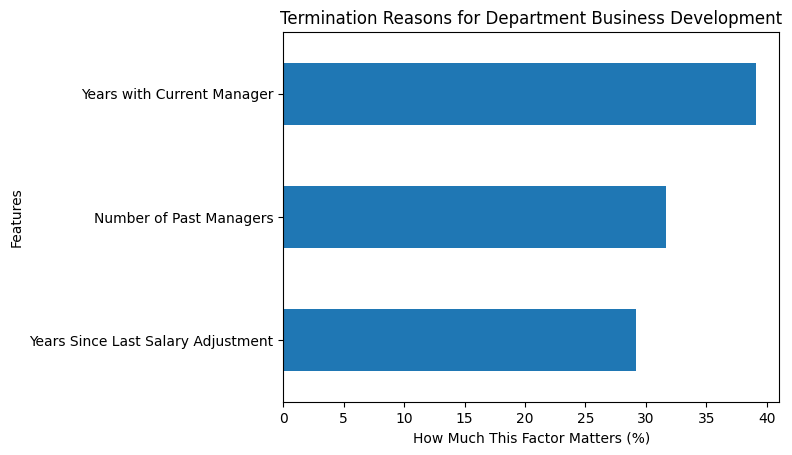

In [32]:
# try sample plot
print(department_shap['department_name'].unique())
sample_department = 'Business Development'

# plot barh for sample department
_temp = termination_reason_by_department[sample_department]['impact_factors']
_temp_df = pd.DataFrame(_temp)
_temp_df.sort_values(by='impact_percentage', ascending=True).plot(
    kind='barh', y='impact_percentage', x='feature_name', legend=False
)
plt.title(f'Termination Reasons for Department {sample_department}')
plt.xlabel('How Much This Factor Matters (%)')
plt.ylabel('Features')
plt.show()

#### evaluation by job level

In [21]:
# level_name
# number of employee preditcted to leave in xx level
# num emp left in xx level
# average termination probability in xx level
# impact factors
# impact value

job_level_shap = shap_with_metadata.groupby('job_level_name')[features].mean().reset_index()
job_level_shap

,job_level_name,total_working_year_z_job_level,total_working_year_z_manager,avg_performance_score,performance_score_z_department,performance_score_z_job_level,year_since_last_salary_adjustment,avg_time_to_promotion,year_with_current_manager,total_ot_hours_3_months,num_past_manager,age,performance_score_z_manager,time_since_last_promotion,total_working_year,num_skills
0,C-Level,-0.000071,-0.003253,-0.017270,-0.001717,0.002460,0.020261,0.001011,0.018850,-0.006871,-0.001606,0.000569,0.000813,-0.001241,0.001292,-0.011901
1,Lead,0.009889,0.002741,-0.035511,-0.002069,0.004076,0.030030,0.005777,0.038838,0.059789,-0.003391,-0.001289,0.003318,0.002712,0.015757,-0.014423
2,Manager,0.003074,-0.003206,-0.001961,-0.001470,0.002460,0.032846,-0.000615,0.033873,-0.006803,-0.001606,0.000382,0.000382,0.001296,0.007131,0.005125
3,Mid-level,0.004181,0.003780,0.002418,-0.001322,-0.000871,-0.001383,0.001894,-0.001985,0.008491,0.047491,-0.000504,0.004011,-0.000486,0.000382,0.002691
4,Senior,0.000678,-0.003075,-0.003945,-0.001644,-0.000786,-0.000046,0.000503,0.000779,-0.004077,-0.002407,0.000084,-0.001178,0.000544,0.001709,0.000036


In [33]:
# write to JSON
json_topic = "termination_reason_by_job_level"
termination_reason_by_job_level = {}

for job_level in job_level_shap['job_level_name'].unique():
    num_emp_left = termination_emp[termination_emp['job_level_name'] == job_level].shape[0]
    num_emp_predicted_to_leave = termination_emp[(termination_emp['job_level_name'] == job_level) & (termination_emp['model_predicted_termination'] == True)].shape[0]
    avg_termination_probability = employee_metadata[employee_metadata['job_level_name'] == job_level]['model_predicted_termination_probability'].mean()

    _level_shap_t = job_level_shap[job_level_shap['job_level_name'] == job_level][features]
    _level_shap_t = _level_shap_t.T.reset_index()
    _level_shap_t.columns = ['feature', 'impact_value']

    abs_mean_shap_value = _level_shap_t['impact_value'].abs().mean()
    _level_shap_t = _level_shap_t[_level_shap_t['impact_value'].abs() > abs_mean_shap_value]

    total_abs_impact = _level_shap_t['impact_value'].abs().sum()
    _level_shap_t['impact_percentage'] = (_level_shap_t['impact_value'].abs() / total_abs_impact) * 100

    _level_shap_t['feature_name'] = _level_shap_t['feature'].map(feature_mapper.FEARURES_MEANING_MAPPER)
    _level_shap_t['recommendation_action'] = _level_shap_t['feature'].map(feature_mapper.FEATURES_ACTION_MAPPER)

    _level_shap_t.sort_values(by='impact_percentage', ascending=False, inplace=True)
    display(_level_shap_t)
    
    # write to JSON
    termination_reason_by_job_level[job_level] = {
        'num_emp_left': num_emp_left,
        'num_emp_predicted_to_leave': num_emp_predicted_to_leave,
        'avg_termination_probability': avg_termination_probability,
        'impact_factors': _level_shap_t[['feature_name', 'impact_percentage', 'recommendation_action']].to_dict(orient='records')
    }
json_result[json_topic] = termination_reason_by_job_level

,feature,impact_value,impact_percentage,feature_name,recommendation_action
5,year_since_last_salary_adjustment,0.020261,26.959811,Years Since Last Salary Adjustment,Review and adjust pay if salary changes have b...
7,year_with_current_manager,0.018850,25.082128,Years with Current Manager,Encourage manager-employee relationship buildi...
2,avg_performance_score,-0.017270,22.979545,Average Performance Score,Provide constructive feedback and support to i...
14,num_skills,-0.011901,15.836048,Number of Skills Acquired,Offer skill development plans and cross-traini...
8,total_ot_hours_3_months,-0.006871,9.142469,Total Overtime Hours (Last 3 Months),Reduce excessive overtime through workload bal...


,feature,impact_value,impact_percentage,feature_name,recommendation_action
8,total_ot_hours_3_months,0.059789,33.230148,Total Overtime Hours (Last 3 Months),Reduce excessive overtime through workload bal...
7,year_with_current_manager,0.038838,21.585405,Years with Current Manager,Encourage manager-employee relationship buildi...
2,avg_performance_score,-0.035511,19.736687,Average Performance Score,Provide constructive feedback and support to i...
5,year_since_last_salary_adjustment,0.030030,16.690375,Years Since Last Salary Adjustment,Review and adjust pay if salary changes have b...
13,total_working_year,0.015757,8.757384,Total Working Years,"Recognize long service with awards, career pro..."


,feature,impact_value,impact_percentage,feature_name,recommendation_action
7,year_with_current_manager,0.033873,45.867051,Years with Current Manager,Encourage manager-employee relationship buildi...
5,year_since_last_salary_adjustment,0.032846,44.476824,Years Since Last Salary Adjustment,Review and adjust pay if salary changes have b...
13,total_working_year,0.007131,9.656125,Total Working Years,"Recognize long service with awards, career pro..."


,feature,impact_value,impact_percentage,feature_name,recommendation_action
9,num_past_manager,0.047491,84.832591,Number of Past Managers,Stabilize management assignments and reduce fr...
8,total_ot_hours_3_months,0.008491,15.167409,Total Overtime Hours (Last 3 Months),Reduce excessive overtime through workload bal...


,feature,impact_value,impact_percentage,feature_name,recommendation_action
8,total_ot_hours_3_months,-0.004077,24.186758,Total Overtime Hours (Last 3 Months),Reduce excessive overtime through workload bal...
2,avg_performance_score,-0.003945,23.398301,Average Performance Score,Provide constructive feedback and support to i...
1,total_working_year_z_manager,-0.003075,18.240195,Total Working Years vs Manager’s Team Average,"If employee tenure is higher than peers, explo..."
9,num_past_manager,-0.002407,14.279749,Number of Past Managers,Stabilize management assignments and reduce fr...
13,total_working_year,0.001709,10.140327,Total Working Years,"Recognize long service with awards, career pro..."
3,performance_score_z_department,-0.001644,9.754670,Performance Score vs Department Average,Identify and solve department-specific perform...


['C-Level' 'Lead' 'Manager' 'Mid-level' 'Senior']


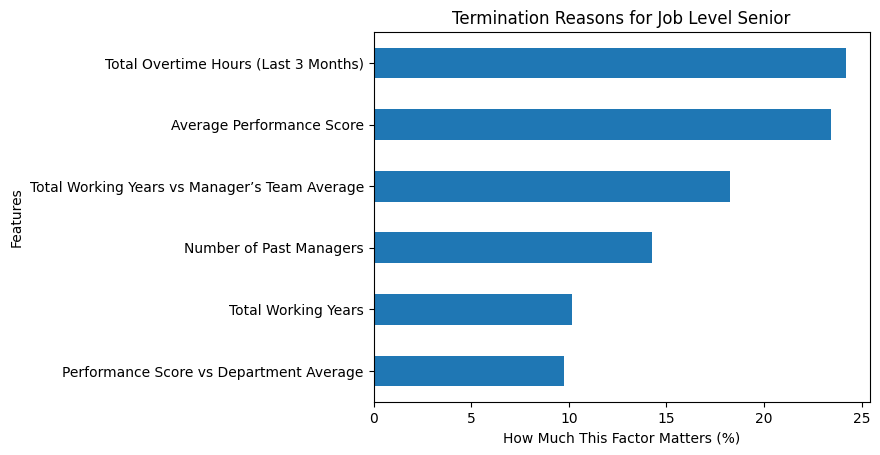

In [36]:
# try sample plot
print(job_level_shap['job_level_name'].unique())
sample_job_level = 'Senior'

# plot barh for sample job level
_temp = termination_reason_by_job_level[sample_job_level]['impact_factors']
_temp_df = pd.DataFrame(_temp)
_temp_df.sort_values(by='impact_percentage', ascending=True).plot(
    kind='barh', y='impact_percentage', x='feature_name', legend=False
)
plt.title(f'Termination Reasons for Job Level {sample_job_level}')
plt.xlabel('How Much This Factor Matters (%)')
plt.ylabel('Features')
plt.show()

#### save final JSON

In [24]:
json_result

{'overall_summary': {'prediction_start_date': '2025-08-31',
  'prediction_end_date': '2025-11-29',
  'total_employees': 18,
  'total_employees_left': 10,
  'employees_predicted_to_leave': 7,
  'average_retention_probability': 0.06642316541518099},
 'termination_proportion_by_department': [{'department_name': 'Operations',
   'termination_count': 3},
  {'department_name': 'Business Development', 'termination_count': 2},
  {'department_name': 'Data Scientist', 'termination_count': 2},
  {'department_name': 'Marketing', 'termination_count': 2},
  {'department_name': 'Project Management', 'termination_count': 2},
  {'department_name': 'Sales', 'termination_count': 2},
  {'department_name': 'Data Consultant', 'termination_count': 1},
  {'department_name': 'Data Engineer', 'termination_count': 1},
  {'department_name': 'Human Resources', 'termination_count': 1},
  {'department_name': 'Software Development', 'termination_count': 1}],
 'termination_proportion_by_job_level': [{'level_name': 'Mi

In [150]:
# save json result to file
with open(f'../{config.TERMINATION_ANALYSIS_OUTPUT}', 'w') as f:
    json.dump(json_result, f, indent=4)